# Phase 1: Extract plates

In [1]:
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np
from collections import defaultdict

In [2]:
target_folder = 'digits'
input_folder = 'Plates2/Vehicle Plates 1280x1280/Vehicle Plates 1280x1280'
output_folder = 'extracted_plates'
threshold = 0.7
fallback_delta = 0.1

os.makedirs(output_folder, exist_ok=True)

target_files = sorted([
    f for f in os.listdir(target_folder)
    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
], reverse=True)

image_files = [
    f for f in os.listdir(input_folder)
    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
]

def match_and_crop(img, img_gray, img_name, threshold_val):
    for target_name in target_files:
        target_path = os.path.join(target_folder, target_name)
        target = cv2.imread(target_path, cv2.IMREAD_GRAYSCALE)

        if target is None:
            print(f"Could not read target image: {target_name}")
            continue

        result = cv2.matchTemplate(img_gray, target, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, max_loc = cv2.minMaxLoc(result)

        if max_val >= threshold_val:
            target_h, target_w = target.shape[:2]
            img_height, img_width = img.shape[:2]

            x1, y1 = max_loc
            x2, y2 = x1 + target_w, y1 + target_h

            top_left = (310, max(y1 - 55, 0))
            bottom_right = (img_width - 310, y2 + 55)

            x_crop1 = max(top_left[0], 0)
            y_crop1 = max(top_left[1], 0)
            x_crop2 = min(bottom_right[0], img_width)
            y_crop2 = min(bottom_right[1], img_height)

            cropped = img[y_crop1:y_crop2, x_crop1:x_crop2]

            cropped_name = f"{img_name[:-4]}_match_with_{target_name}"
            cropped_path = os.path.join(output_folder, cropped_name)
            cv2.imwrite(cropped_path, cropped)

            return True, max_val, target_name
    return False, None, None

match_count = 0
for img_name in image_files:
    img_path = os.path.join(input_folder, img_name)
    img = cv2.imread(img_path)

    if img is None:
        print(f"Could not read: {img_name}")
        continue

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    matched, score, matched_target = match_and_crop(img, img_gray, img_name, threshold)

    if not matched:
        print(f"Not found in strict mode: {img_name}")
        matched, score, matched_target = match_and_crop(img, img_gray, img_name, threshold - fallback_delta)
        print(f"Match found for target {matched_target} in {img_name} (score: {score:.2f})")

    if matched:
        match_count += 1
        # print(f"Match found for target {matched_target} in {img_name} (score: {score:.2f})")

print(f"\nDone. Found {match_count} total matching image(s).")


Not found in strict mode: 136.png
Match found for target 9.jpg in 136.png (score: 0.68)
Not found in strict mode: 157.png
Match found for target 9.jpg in 157.png (score: 0.63)
Not found in strict mode: 158.png
Match found for target 9.jpg in 158.png (score: 0.69)
Not found in strict mode: 178.png
Match found for target 8.jpg in 178.png (score: 0.67)
Not found in strict mode: 182.png
Match found for target 8.jpg in 182.png (score: 0.63)
Not found in strict mode: 184.png
Match found for target 9.jpg in 184.png (score: 0.61)
Not found in strict mode: 26.png
Match found for target 9.jpg in 26.png (score: 0.60)
Not found in strict mode: 60.png
Match found for target 9.jpg in 60.png (score: 0.66)

Done. Found 217 total matching image(s).


# Phase 2: Extract alphabets

In [3]:
plates_dir = 'extracted_plates'
base_output_folder = "output"

deskew_gray_image_path = os.path.join(base_output_folder, "1-deskew_gray_image")
blurred_path = os.path.join(base_output_folder, "2-blurred")
thresh_path = os.path.join(base_output_folder, "3-thresh")
dilated_path = os.path.join(base_output_folder, "4-dilated")
dilated_output_dir = os.path.join(base_output_folder, "Extracted_characters_dilated")
thresh_output_dir = os.path.join(base_output_folder, "Extracted_characters_thresh")
full_composite_dir = os.path.join(base_output_folder, "full_composite")

# ایجاد پوشه‌ها
os.makedirs(base_output_folder, exist_ok=True)
os.makedirs(deskew_gray_image_path, exist_ok=True)
os.makedirs(blurred_path, exist_ok=True)
os.makedirs(thresh_path, exist_ok=True)
os.makedirs(dilated_path, exist_ok=True)
os.makedirs(dilated_output_dir, exist_ok=True)
os.makedirs(thresh_output_dir, exist_ok=True)
os.makedirs(full_composite_dir, exist_ok=True)


def deskew_image(img):
    """صاف کردن تصویر با Hough Line Detection"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    lines = cv2.HoughLines(edges, 1, np.pi/180, 100)

    if lines is not None:
        angles = []
        for rho, theta in lines[:, 0]:
            angle = (theta - np.pi/2) * 180/np.pi
            if -45 < angle < 45:
                angles.append(angle)
        if angles:
            avg_angle = np.mean(angles)
            (h, w) = img.shape[:2]
            M = cv2.getRotationMatrix2D((w // 2, h // 2), avg_angle, 1.0)
            img = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR)
    return img

def put_label(img, label):
    img = cv2.copyMakeBorder(img, 20, 0, 0, 0, cv2.BORDER_CONSTANT, value=255)
    cv2.putText(img, label, (5, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 0, 1)
    return img

# ساخت تصویر ترکیبی کامل
def build_full_composite(plate_id, char_images):
    try:
        gray = cv2.imread(f"{deskew_gray_image_path}/{plate_id}_deskew_gray.png", cv2.IMREAD_GRAYSCALE)
        blurred = cv2.imread(f"{blurred_path}/{plate_id}_blurred.png", cv2.IMREAD_GRAYSCALE)
        thresh = cv2.imread(f"{thresh_path}/{plate_id}_thresh.png", cv2.IMREAD_GRAYSCALE)
        dilated = cv2.imread(f"{dilated_path}/{plate_id}_dilated.png", cv2.IMREAD_GRAYSCALE)

        steps = [gray, blurred, thresh, dilated]
        step_labels = ["gray", "blurred", "thresh", "dilated"]
        steps_labeled = [put_label(cv2.resize(img, (100, 100)), lbl) for img, lbl in zip(steps, step_labels)]
        row1 = cv2.hconcat(steps_labeled)

        chars_labeled = []
        for i, char in enumerate(char_images):
            char = cv2.resize(char, (28, 28))
            char_labeled = put_label(char, f"{i+1}")
            chars_labeled.append(char_labeled)

        while len(chars_labeled) < 8:
            empty = put_label(255 * np.ones((28, 28), dtype=np.uint8), "")
            chars_labeled.append(empty)

        row2 = cv2.hconcat(chars_labeled)
        row2_resized = cv2.resize(row2, (row1.shape[1], row1.shape[0]))
        full = cv2.vconcat([row1, row2_resized])

        save_path = f"{full_composite_dir}/{plate_id}_full.png"
        cv2.imwrite(save_path, full)
        print(f"🖼 تصویر کامل ذخیره شد: {save_path}")

    except Exception as e:
        print(f"⚠️ خطا در ساخت تصویر کامل {plate_id}: {e}")

# تابع استخراج و ذخیره کاراکترها + ساخت ترکیب
def func(num_labels, stats, thresh, output_dir, plate_id):
    components = []
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        if 80 < area < 6000 and h > 13 and w > 4:
            components.append((x, y, w, h, area))

    if len(components) == 0:
        print(f"⚠️ هیچ کاراکتری شناسایی نشد در {plate_id}")
        return

    components = sorted(components, key=lambda b: b[3], reverse=True)[:8]
    components = sorted(components, key=lambda b: b[0])

    char_images = []

    for idx, (x, y, w, h, _) in enumerate(components):
        char_img = thresh[y:y+h, x:x+w]

        # معکوس کردن رنگ (کاراکتر مشکی روی سفید)
        char_img = 255 - char_img

        # کوچک‌سازی کاراکتر به ابعاد کوچکتر (مثلاً 100x100)
        resized_char = cv2.resize(char_img, (23, 23))

        # ساخت بوم سفید
        canvas = 255 * np.ones((28, 28), dtype=np.uint8)

        # محاسبه مکان شروع برای قرارگیری وسط
        start_y = (28 - 23) // 2
        start_x = (28 - 23) // 2

        # قرار دادن تصویر کوچک‌شده در مرکز
        canvas[start_y:start_y+23, start_x:start_x+23] = resized_char

        save_path = os.path.join(output_dir, f"{plate_id}_char_{idx+1}.png")
        cv2.imwrite(save_path, canvas)
        char_images.append(canvas)
        print(f"✅ ذخیره شد: {save_path}")

    # ساخت تصویر نهایی
    build_full_composite(plate_id, char_images)
    

def extract_characters_from_plate(image_path, plate_id):
    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ تصویر یافت نشد: {image_path}")
        return
    
    img = deskew_image(img)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0) # using 5*5 filter instead of 3*3 
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # عملیات مورفولوژیک قوی‌تر
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
    dilated = cv2.dilate(morph, kernel, iterations=2)  # افزایش iterations 
        
    # show_image(dilated)
    cv2.imwrite(os.path.join(deskew_gray_image_path, f"{plate_id}_deskew_gray.png"), gray)
    cv2.imwrite(os.path.join(blurred_path, f"{plate_id}_blurred.png"), blurred)
    cv2.imwrite(os.path.join(thresh_path, f"{plate_id}_thresh.png"), thresh)
    cv2.imwrite(os.path.join(dilated_path, f"{plate_id}_dilated.png"), dilated)

    # connected components
    num_labels_dilated, labels_dilated, stats_dilated, centroids_dilated = cv2.connectedComponentsWithStats(dilated, connectivity=8)
    num_labels_thresh, labels_thresh, stats_thresh, centroids_thresh = cv2.connectedComponentsWithStats(thresh, connectivity=8)

    func(num_labels_dilated, stats_dilated, thresh, dilated_output_dir,plate_id)
    func(num_labels_thresh, stats_thresh, thresh, thresh_output_dir,plate_id)

# اجرای پردازش روی تمام پلاک‌ها
for fname in os.listdir(plates_dir):
    if fname.endswith(('.png', '.jpg')):
        plate_path = os.path.join(plates_dir, fname)
        plate_id = os.path.splitext(fname)[0]
        extract_characters_from_plate(plate_path, plate_id)


✅ ذخیره شد: output\Extracted_characters_dilated\100_match_with_4_char_1.png
✅ ذخیره شد: output\Extracted_characters_dilated\100_match_with_4_char_2.png
✅ ذخیره شد: output\Extracted_characters_dilated\100_match_with_4_char_3.png
✅ ذخیره شد: output\Extracted_characters_dilated\100_match_with_4_char_4.png
✅ ذخیره شد: output\Extracted_characters_dilated\100_match_with_4_char_5.png
✅ ذخیره شد: output\Extracted_characters_dilated\100_match_with_4_char_6.png
✅ ذخیره شد: output\Extracted_characters_dilated\100_match_with_4_char_7.png
🖼 تصویر کامل ذخیره شد: output\full_composite/100_match_with_4_full.png
✅ ذخیره شد: output\Extracted_characters_thresh\100_match_with_4_char_1.png
✅ ذخیره شد: output\Extracted_characters_thresh\100_match_with_4_char_2.png
✅ ذخیره شد: output\Extracted_characters_thresh\100_match_with_4_char_3.png
✅ ذخیره شد: output\Extracted_characters_thresh\100_match_with_4_char_4.png
✅ ذخیره شد: output\Extracted_characters_thresh\100_match_with_4_char_5.png
✅ ذخیره شد: output\Ext

# Phase 3: Train models

In [4]:
from PIL import Image
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from skimage.feature import hog
import fnmatch
import shutil
import random
from scipy.ndimage import gaussian_filter, map_coordinates

##### preprocess train data (crop the paddings(white spaces)) and extract the characters

In [5]:
def crop_character(img_array):
    """
    Crop the character from the image by removing white borders.
    No padding is added.
    """
    inverted = 255 - img_array
    coords = cv2.findNonZero(inverted)
    if coords is None:
        return img_array
    x, y, w, h = cv2.boundingRect(coords)
    cropped = img_array[y : y + h, x : x + w]
    return cropped

input_root = "alpha"  # root input folder
output_root = "alpha_cropped"  # output folder with same structure
target_size = (28, 28)  # resize target
os.makedirs(output_root, exist_ok=True)

for root, dirs, files in os.walk(input_root):
    for file in files:
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            input_path = os.path.join(root, file)
            relative_path = os.path.relpath(root, input_root)
            output_dir = os.path.join(output_root, relative_path)
            os.makedirs(output_dir, exist_ok=True)

            try:
                img = Image.open(input_path).convert("L")
                img_array = np.array(img)

                # Crop character and resize to 50x50
                cropped = crop_character(img_array)
                resized = cv2.resize(cropped, target_size, interpolation=cv2.INTER_AREA)

                # Save the result
                save_path = os.path.join(output_dir, file)
                cv2.imwrite(save_path, resized)
                print(f"✅ Saved: {save_path}")
            except Exception as e:
                print(f"❌ Error processing {input_path}: {e}")

✅ Saved: alpha_cropped\10-d\100d.jpg
✅ Saved: alpha_cropped\10-d\10d.jpg
✅ Saved: alpha_cropped\10-d\11d.jpg
✅ Saved: alpha_cropped\10-d\12d.jpg
✅ Saved: alpha_cropped\10-d\13d.jpg
✅ Saved: alpha_cropped\10-d\14d.jpg
✅ Saved: alpha_cropped\10-d\15d.jpg
✅ Saved: alpha_cropped\10-d\16d.jpg
✅ Saved: alpha_cropped\10-d\17d.jpg
✅ Saved: alpha_cropped\10-d\18d.jpg
✅ Saved: alpha_cropped\10-d\19d.jpg
✅ Saved: alpha_cropped\10-d\1d.jpg
✅ Saved: alpha_cropped\10-d\20d.jpg
✅ Saved: alpha_cropped\10-d\21d.jpg
✅ Saved: alpha_cropped\10-d\22d.jpg
✅ Saved: alpha_cropped\10-d\23d.jpg
✅ Saved: alpha_cropped\10-d\24d.jpg
✅ Saved: alpha_cropped\10-d\25d.jpg
✅ Saved: alpha_cropped\10-d\26d.jpg
✅ Saved: alpha_cropped\10-d\27d.jpg
✅ Saved: alpha_cropped\10-d\28d.jpg
✅ Saved: alpha_cropped\10-d\29d.jpg
✅ Saved: alpha_cropped\10-d\2d.jpg
✅ Saved: alpha_cropped\10-d\30d.jpg
✅ Saved: alpha_cropped\10-d\31d.jpg
✅ Saved: alpha_cropped\10-d\32d.jpg
✅ Saved: alpha_cropped\10-d\33d.jpg
✅ Saved: alpha_cropped\10-d\3

#### Train the models

In [6]:
def extract_hog_features(img_array):
    features = hog(img_array, orientations=9, pixels_per_cell=(4, 4), cells_per_block=(2, 2), block_norm='L2-Hys')
    return features

def elastic_transform(image, alpha=34, sigma=4):
    image = np.array(image)
    random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))

    distorted = map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)
    return Image.fromarray(distorted.astype(np.uint8))

def add_noise(img):
    noisy = np.array(img).astype(np.float32)
    noise = np.random.normal(0, 10, noisy.shape)
    noisy = np.clip(noisy + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy)


def random_affine(img):
    angle = random.uniform(-10, 10)
    translate = (random.uniform(-2, 2), random.uniform(-2, 2))
    scale = random.uniform(0.9, 1.1)

    return img.rotate(angle, resample=Image.BICUBIC, fillcolor=255).transform(
        img.size, Image.AFFINE,
        (scale, 0, translate[0], 0, scale, translate[1]),
        resample=Image.BICUBIC,
        fillcolor=255
    )

def augment_image(img):
    augmented_images = []

    if not isinstance(img, Image.Image):
        img = Image.fromarray(img)

    augmented_images.append(random_affine(img))
    augmented_images.append(add_noise(img))
    augmented_images.append(elastic_transform(img))

    return augmented_images


image_size = (28, 28)
dataset_path = "alpha_cropped" 

X, y = [], []
labels = {}

for idx, label_folder in enumerate(sorted(os.listdir(dataset_path))):
    folder_path = os.path.join(dataset_path, label_folder)
    if os.path.isdir(folder_path):
        labels[idx] = label_folder
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_file)
            try:
                img = Image.open(img_path).convert("L").resize(image_size)
                img_array = np.array(img)
                
                # Original image features
                hog_features = extract_hog_features(img_array)
                X.append(hog_features)
                y.append(idx)

                # Augmented images (same label)
                for aug_img in augment_image(img):
                    aug_array = np.array(aug_img)
                    hog_aug = extract_hog_features(aug_array)
                    X.append(hog_aug)
                    y.append(idx)

            except Exception as e:
                print(f"خطا در پردازش {img_path}: {e}")

# نرمال‌سازی
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# کاهش ابعاد با PCA
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

# تقسیم داده‌ها به آموزش و تست
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.1, random_state=42)

# مدل SVM
svm_model = SVC(kernel='linear')
svm_scores = cross_val_score(svm_model, X_train, y_train, cv=5)
print(f"SVM دقت: {np.mean(svm_scores):.2f} ± {np.std(svm_scores):.2f}")

# مدل درخت تصمیم
tree_model = DecisionTreeClassifier()
tree_scores = cross_val_score(tree_model, X_train, y_train, cv=5)

svm_model.fit(X_train, y_train)
tree_model.fit(X_train, y_train)

print(f"درخت تصمیم دقت: {np.mean(tree_scores):.2f} ± {np.std(tree_scores):.2f}")


SVM دقت: 0.89 ± 0.01
درخت تصمیم دقت: 0.69 ± 0.01


# Phase 4: Test

In [7]:
image_size = (28, 28)

base_output_folder = "output"
base_path = os.path.join(base_output_folder, "Extracted_characters_thresh")

predict_dir = "predicted"
os.makedirs(predict_dir, exist_ok=True)

output_dir = os.path.join(predict_dir, "1")
os.makedirs(output_dir, exist_ok=True)


svm_plate_predictions = defaultdict(list)
tree_plate_predictions = defaultdict(list)
def predict_image_batch(img_path, file_name):
    try:
        img = Image.open(img_path).convert("L").resize(image_size)
        img_array = np.array(img)
        hog_features = extract_hog_features(img_array)
        img_scaled = scaler.transform([hog_features])
        img_pca = pca.transform(img_scaled)

        svm_pred = svm_model.predict(img_pca)[0]
        tree_pred = tree_model.predict(img_pca)[0]

        svm_label = labels[svm_pred].split("-")[1]
        tree_label = labels[tree_pred].split("-")[1]

        # استخراج شماره پلاک
        plate_id = file_name.split("_")[0]

        svm_plate_predictions[plate_id].append(svm_label)
        tree_plate_predictions[plate_id].append(tree_label)

        # save images
        save_filename = f"{file_name}_SVM-{svm_label}_DT-{tree_label}.png"
        save_path = os.path.join(output_dir, save_filename)
        cv2.imwrite(save_path, img_array)

        # print(f"✅ Saved: {save_filename}")
    except Exception as e:
        print(f"❌ Error processing {img_path}: {e}")

# Predict on all images in base_path
for index, img_file in enumerate(sorted(os.listdir(base_path))):
    img_path = os.path.join(base_path, img_file)
    if os.path.isfile(img_path):
        file_name = img_file.split(".")[0]
        predict_image_batch(img_path, file_name)
        
def save_predictions_to_txt(predictions_dict, output_file):
    with open(output_file, "w", encoding="utf-8") as f:
        f.write("name,plate\n")
        for plate_id in sorted(predictions_dict.keys(), key=lambda x: int(x)):
            preds = predictions_dict[plate_id]
            line = f"{plate_id}," + ",".join(preds)
            f.write(line + "\n")

save_predictions_to_txt(svm_plate_predictions, "svm_predictions.txt")
save_predictions_to_txt(tree_plate_predictions, "tree_predictions.txt")

# Phase 5: Evaluation

In [8]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt

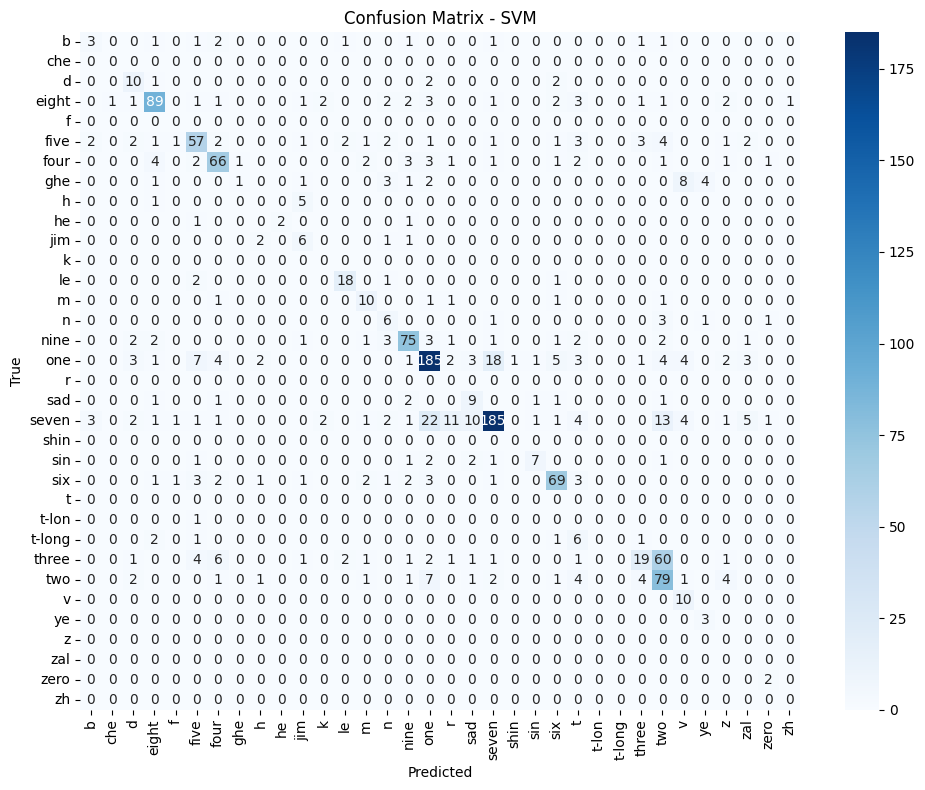

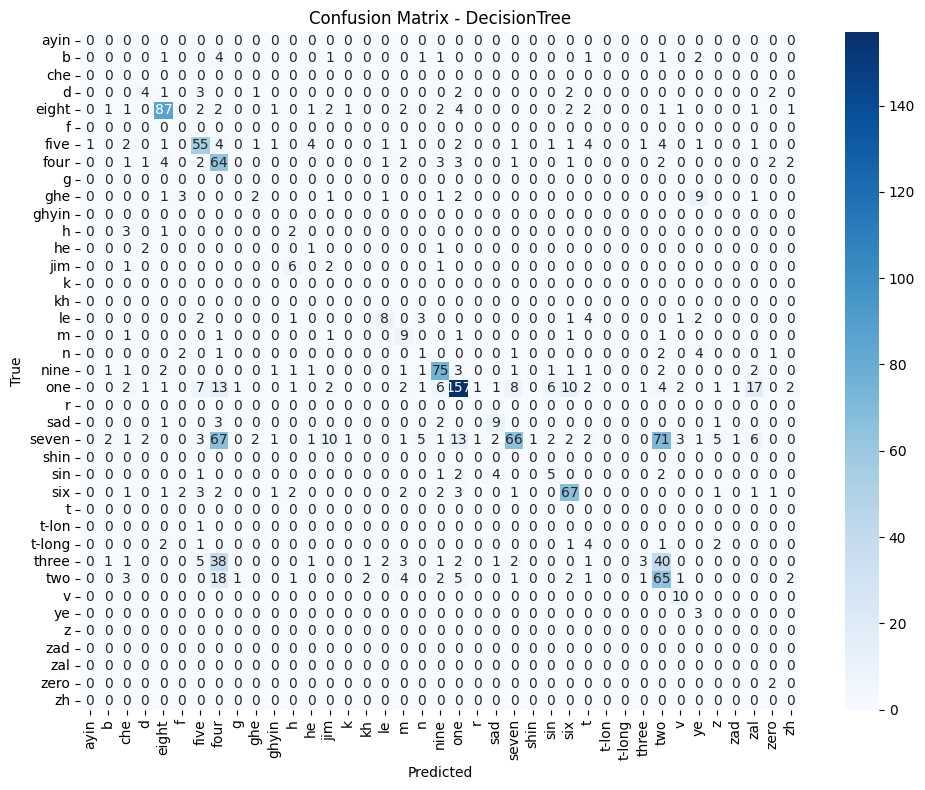

In [9]:
true_plates = {}
with open("./Plates2/plate_labels.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()[1:]  # رد کردن هدر
    for line in lines:
        parts = line.strip().split(",")
        true_plates[parts[0]] = parts[1:]
        
def evaluate_model(true_plates, predicted_plates, model_name, output_txt_file):
    all_true = []
    all_pred = []
    exact_match_count = 0
    common_ids = set(true_plates.keys()) & set(predicted_plates.keys())

    for plate_id in sorted(common_ids, key=lambda x: int(x)):
        true = true_plates[plate_id]
        pred = predicted_plates[plate_id]

        # فقط اگر طول‌شون برابر باشه لحاظ بشه
        if len(true) != len(pred):
            continue

        if true == pred:
            exact_match_count += 1

        all_true.extend(true)
        all_pred.extend(pred)

    total_plates = len(common_ids)
    plate_accuracy = exact_match_count / total_plates if total_plates else 0
    acc = accuracy_score(all_true, all_pred)
    prec = precision_score(all_true, all_pred, average='macro', zero_division=0)
    rec = recall_score(all_true, all_pred, average='macro', zero_division=0)
    cm = confusion_matrix(all_true, all_pred, labels=np.unique(all_true + all_pred))
    labels_sorted = list(np.unique(all_true + all_pred))

    with open(output_txt_file, "w", encoding="utf-8") as f:
        f.write(f"🔹 {model_name} Evaluation\n")
        f.write(f"✔️ دقت کامل پلاک‌ها: {plate_accuracy:.2f}\n")
        f.write(f"✔️ Accuracy (کاراکتر): {acc:.2f}\n")
        f.write(f"✔️ Precision (macro): {prec:.2f}\n")
        f.write(f"✔️ Recall (macro): {rec:.2f}\n\n")
        f.write("📊 Confusion Matrix:\n")
        f.write("True\\Pred" + "\t" + "\t".join(labels_sorted) + "\n")
        for i, row in enumerate(cm):
            f.write(labels_sorted[i] + "\t" + "\t".join(str(x) for x in row) + "\n")

    # ذخیره تصویر گرافیکی
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels_sorted, yticklabels=labels_sorted, cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"{model_name}_confusion_matrix.png")
    plt.show()

# اجرا برای هر مدل
evaluate_model(true_plates, svm_plate_predictions, "SVM", "svm_evaluation.txt")
evaluate_model(true_plates, tree_plate_predictions, "DecisionTree", "tree_evaluation.txt")
